We will start by downloading IMDB data

In [65]:
import os
import random
import spacy
import string
import pickle as pkl
from collections import Counter
import numpy as np
import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [39]:
#Download and preprocess data into the right format

def read_files_into_list(directory):
    '''Read text files from the directory into a list'''
    
    files = os.listdir(directory)
    list_of_files = []
    
    for file in files:
        with open(directory+file, 'r') as content_file:
            content = content_file.read()
            list_of_files.append(content.replace('<br />','')) #remove <br />
    return list_of_files

def create_model_set(positive_reviews_list, negative_reviews_list):
    '''Create shuffled list of targets and inputs'''
    #Add target variable 
    pos = [1]*len(positive_reviews_list)
    neg = [0]*len(negative_reviews_list)

    #Create lists of inputs and targets
    inputs = negative_reviews_list+positive_reviews_list
    targets = neg+pos

    #Shuffle the data
    random.seed(5)
    data_ind = list(range(0,len(inputs)))
    random.shuffle(data_ind)
    
    shuffled_inputs = [inputs[i] for i in data_ind]
    shuffled_targets = [targets[i] for i in data_ind]
    
    return shuffled_inputs, shuffled_targets


train_negative_reviews_list = read_files_into_list('../train_data.nosync/neg/')
train_positive_reviews_list = read_files_into_list('../train_data.nosync/pos/')

all_train_data, all_train_targets = create_model_set(train_positive_reviews_list, 
                                  train_negative_reviews_list)

test_negative_reviews_list = read_files_into_list('../test_data.nosync/neg/')
test_positive_reviews_list = read_files_into_list('../test_data.nosync/neg/')

all_test_data, all_test_targets = create_model_set(test_positive_reviews_list, 
                                  test_negative_reviews_list)


In [40]:
# Split train data into actual train and validation sets

train_split = 20000
train_data = all_train_data[:train_split]
train_targets = all_train_targets[:train_split]

val_data = all_train_data[train_split:]
val_targets = all_train_targets[train_split:]

test_data = all_test_data
test_targets = all_test_targets

print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [41]:
# Random sample from train dataset
print (train_data[random.randint(0, len(train_data) - 1)])

I am a big fan of this film and found the TV mini series "Children of The Dust", the version fans should look for. At least 20 minutes or more are cut on the DVD version of this film.I would also suggest viewers who enjoyed this film to check out the book there is a more rounded storyline with Corby/Whitewolf and Rachel, more on Black History and Buffalo Solders. There were two many storylines for the series or this film.Sidney Poitier only shows he gets better with age, the talent just keeps growing the chemistry between his character of Gypsy Smith and Regina Taylor were wonderful viewing. I also enjoyed the Billy Wirth/Joanna Going storyline, they seems to play off each other well.Billy Wirth is of course the "Model of Indian Vision". The look, the attitude, the dream of every woman who was wanted to be carried off in one of those romance novels by a native hero. Worked for me also.Much more could have been done with this storyline but it did give the viewer a brief glimpse of racia

In [42]:
# Tokenization function using Spacy

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]


In [45]:
# This is the code cell that tokenizes train/val/test datasets

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset: #for each sentence
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data)
pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data)
pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data


In [46]:
#If Downloading tokenized datasets

# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4648501


Now, we are going to create the vocabulary of most common tokens in the training set.

In [48]:
#Try 10,000 most common tokens

max_vocab_size = 10000
# save index 1 for unk and 0 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size)) #* unzips the tuples
    id2token = list(vocab) #list of words
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) # dictionary of words and indices 
    id2token = ['<pad>', '<unk>'] + id2token #add pad and unknown to the beginning
    token2id['<pad>'] = PAD_IDX  #add pad symbol to the dictionary
    token2id['<unk>'] = UNK_IDX  #add unkown symbol to the dictionary
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [49]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 7480 ; token destructive
Token destructive; token id 7480


In [50]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens] #tokenizes 10k words
        indices_data.append(index_list) #list of lists: indices of tokens for each sentence
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


Now we are going to create PyTorch DataLoader 

In [53]:
MAX_SENTENCE_LENGTH = 200 #80/90% of document

class imdb_Dataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list): #initialize target and input
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        tokens = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [tokens, len(tokens), label]

def imdb_collate_func(batch): #padding so all data have same length
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2]) #list of labels
        length_list.append(datum[1]) #length of text
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = imdb_Dataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True) #shuffle train

val_dataset = imdb_Dataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True) #shuffle val

test_dataset = imdb_Dataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False) #don't shuffle test

#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

Here we will define Bag-of-Words model in PyTorch

In [55]:
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float() #make same shape as out
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

In [63]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

train_acc_hist = []
val_acc_hist = []

for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train() #set training mode
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad() #zero our gradients
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch) #calculate loss
        loss.backward() #backpropagate
        optimizer.step() #update weights
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            
            #Save performance for plotting
            val_acc_hist.append(val_acc)
            train_acc = test_model(train_loader, model)
            train_acc_hist.append(train_acc)
    


Epoch: [1/10], Step: [101/625], Validation Acc: 84.9
Epoch: [1/10], Step: [201/625], Validation Acc: 85.12
Epoch: [1/10], Step: [301/625], Validation Acc: 85.14
Epoch: [1/10], Step: [401/625], Validation Acc: 85.08
Epoch: [1/10], Step: [501/625], Validation Acc: 84.66
Epoch: [1/10], Step: [601/625], Validation Acc: 85.2
Epoch: [2/10], Step: [101/625], Validation Acc: 84.86
Epoch: [2/10], Step: [201/625], Validation Acc: 85.34
Epoch: [2/10], Step: [301/625], Validation Acc: 84.78
Epoch: [2/10], Step: [401/625], Validation Acc: 85.02
Epoch: [2/10], Step: [501/625], Validation Acc: 84.92
Epoch: [2/10], Step: [601/625], Validation Acc: 84.52
Epoch: [3/10], Step: [101/625], Validation Acc: 84.76
Epoch: [3/10], Step: [201/625], Validation Acc: 84.72
Epoch: [3/10], Step: [301/625], Validation Acc: 84.82
Epoch: [3/10], Step: [401/625], Validation Acc: 84.62
Epoch: [3/10], Step: [501/625], Validation Acc: 85.04
Epoch: [3/10], Step: [601/625], Validation Acc: 84.1
Epoch: [4/10], Step: [101/625],

In [64]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 10 epochs
Val Acc 84.3
Test Acc 50.0


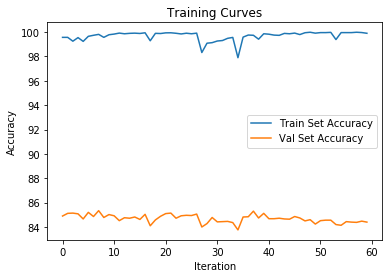

In [80]:
plt.plot(train_acc_hist, label='Train Set Accuracy')
plt.plot(val_acc_hist, label='Val Set Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.title('Training Curves')
plt.legend()
plt.show()